In [35]:
import os
import json
import urllib.request
import requests
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import shutil
import json
import random
import numpy as np
import cv2

import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Concatenate, Conv2DTranspose
from keras.layers import UpSampling2D, BatchNormalization, Lambda, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

---

### Setting up data generator

---

In [36]:
# Instantiate an ImageDataGenerator object with rescaling to normalize images
datagen = ImageDataGenerator(rescale=1./255)


# Generate batches of image data from data preprocessing step
train_image_generator = datagen.flow_from_directory(
    './data/train/plastic_bottle_images',  # Directory path for training images
    target_size=(128, 128),                
    class_mode=None,                       
    seed=42,                               
    batch_size=16,                         # Number of images to process at a time
    shuffle=True                           # Shuffle the dataset before each epoch
)

# Generate batches of mask data
train_mask_generator = datagen.flow_from_directory(
    './data/train/plastic_bottle_masks',   
    target_size=(128, 128),                
    color_mode='grayscale',                
    class_mode=None,                        
    seed=42,                              
    batch_size=16,                         
    shuffle=True                           
)

# Combine image and mask generators into one generator for training
train_generator = zip(train_image_generator, train_mask_generator)


# Do the same for validation set
val_image_generator = datagen.flow_from_directory(
    './data/val/plastic_bottle_images',    
    target_size=(128, 128),                
    class_mode=None,                       
    seed=42,                               
    batch_size=16,                         
    shuffle=True                           
)

val_mask_generator = datagen.flow_from_directory(
    './data/val/plastic_bottle_masks',     
    target_size=(128, 128),                
    color_mode='grayscale',                
    class_mode=None,                       
    seed=42,                               
    batch_size=16,                         
    shuffle=True                           
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 747 images belonging to 1 classes.
Found 747 images belonging to 1 classes.
Found 82 images belonging to 1 classes.
Found 82 images belonging to 1 classes.


---
### U-net Model Definition

The U-net model will be defined for our segmentation task. The code used for defining the U-net in the following two cells is sourced from this repository:
[python_for_image_processing_APEER](https://github.com/bnsreenu/python_for_image_processing_APEER)

---



In [17]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [18]:
# Build U-Net using the defined blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary segmentation
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes

    model = Model(inputs, outputs, name="U-Net")
    return model

---

### Build and compile the model
Note that since we want to do the segmentation only on bottle objects, the number of classes will be set to one.

---

In [20]:
input_shape = (128, 128, 3)
model = build_unet(input_shape, n_classes=1)
# Binary segmentation --> binary_crossentropy loss function 
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 128, 128, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_40 (BatchN  (None, 128, 128, 64  256        ['conv2d_41[0][0]']              
 ormalization)                  )                                                     

 activation_48 (Activation)     (None, 8, 8, 1024)   0           ['batch_normalization_48[0][0]'] 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 8, 8, 1024)   9438208     ['activation_48[0][0]']          
                                                                                                  
 batch_normalization_49 (BatchN  (None, 8, 8, 1024)  4096        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)     (None, 8, 8, 1024)   0           ['batch_normalization_49[0][0]'] 
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 16, 16, 512)  2097664    ['activation_49[0][0]']          
 spose)   

                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 64  36928       ['activation_56[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_57 (BatchN  (None, 128, 128, 64  256        ['conv2d_58[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_57 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_57[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_59

---

### Train the model

---

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    batch_size=16,
    epochs=20,
    steps_per_epoch=len(train_image_generator), # This many batches will be processed for training in one epoch
    validation_steps=len(val_image_generator) 
)

In [ ]:
# Save accuracy and loss records
with open('./saved_models_and_history/history_unet.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
# Save the model
model.save('./saved_models_and_history/unet.h5')

---

### Plot accuracy and loss

---

In [28]:
# Load the file
with open('./saved_models_and_history/history_unet.json', 'r') as f:
    loaded_history = json.load(f)

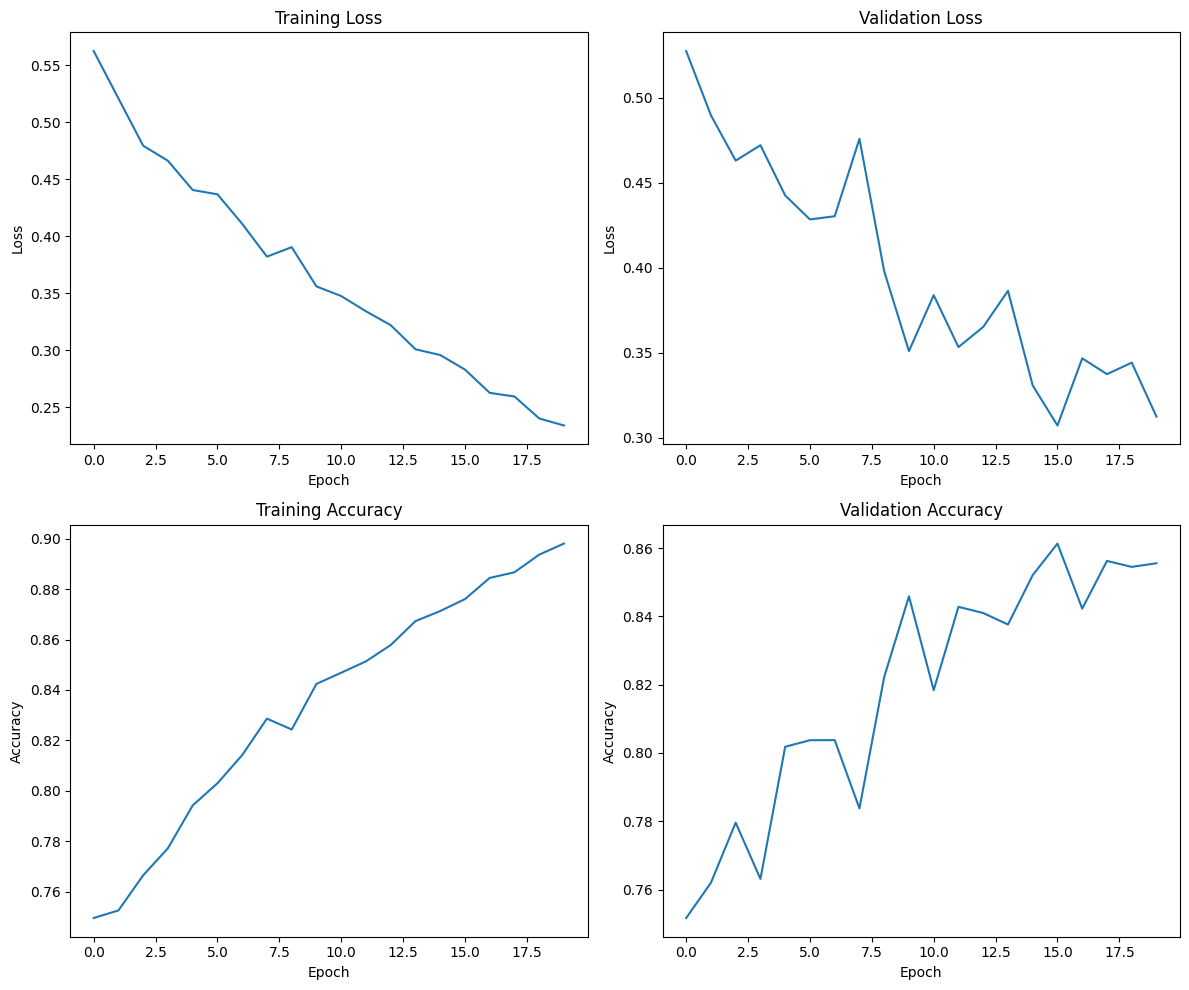

In [29]:
# Using the loaded_history for plotting

plt.figure(figsize=(12, 10))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(loaded_history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(loaded_history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(loaded_history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot validation accuracy
plt.subplot(2, 2, 4)
plt.plot(loaded_history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()



---

### U-Net output (Bottle segmentation)

---

In [30]:
model = load_model("./saved_models_and_history/unet.h5")

1/1 [==============================] - 0s 40ms/step


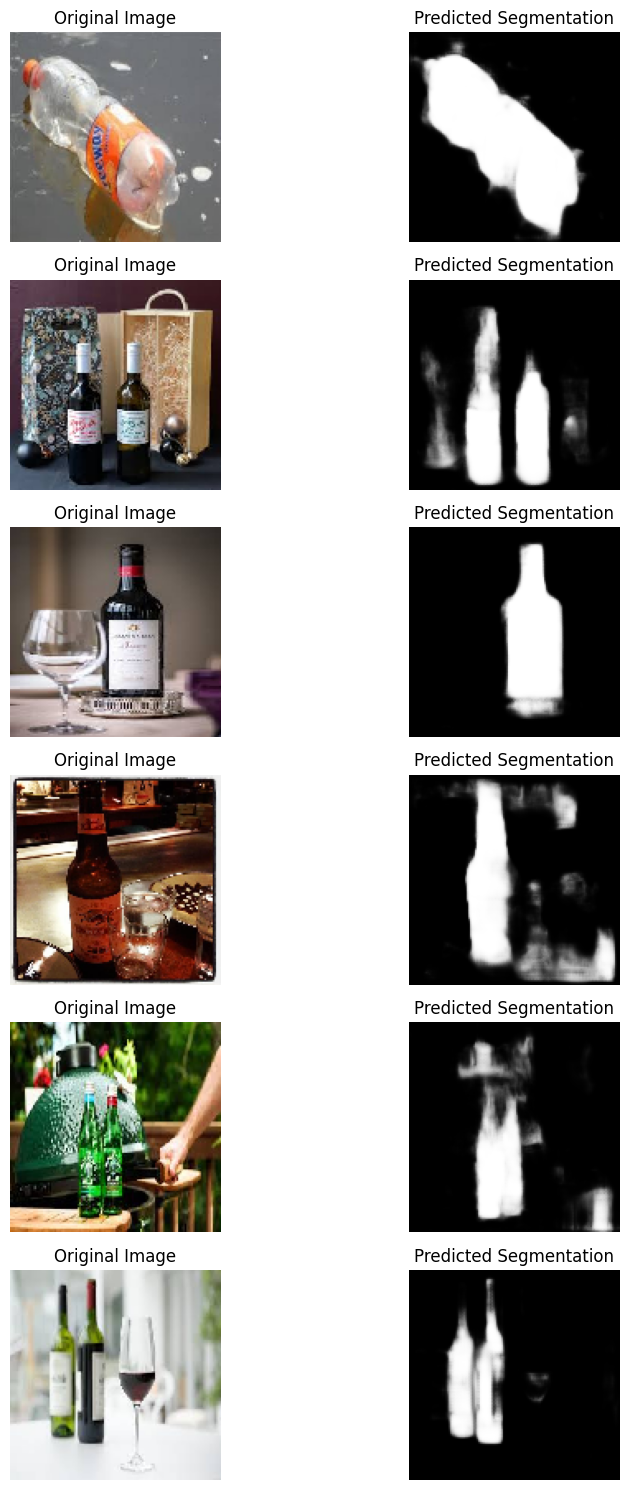

In [31]:
image_directory = './data/sample_images'

# List image files
image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

originals = []
predictions = []

for img_file in image_files:
    img_path = os.path.join(image_directory, img_file)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize and expand dims
    
    # Predict
    pred = model.predict(img_array)
    pred_image = pred.squeeze()  
    
    originals.append(img)
    predictions.append(pred_image)

fig, axs = plt.subplots(len(image_files), 2, figsize=(10, 15))

for i, (orig, pred) in enumerate(zip(originals, predictions)):
    axs[i, 0].imshow(orig)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(pred, cmap='gray')  
    axs[i, 1].set_title('Predicted Segmentation')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

---


#  Fine-tune the U-Net Model

The trained U-Net has already learned important features from diverse datasets, such as different edges, textures, and patterns. By fine-tuning, we build upon this foundational knowledge, accelerating training and potentially boosting performance.

Additionally, the project pipeline involves Faster R-CNN for object detection, followed by U-Net for detailed segmentation. The predominant feature in the Faster R-CNN's output image is the bottle. This differs from the distribution observed in the U-Net's training dataset. By fine-tuning U-Net **on images cropped using Faster R-CNN bounding boxes**, we promote a proper integration between the two stages.

#### Data for fine-tuning U-Net
After subjecting some images to the trained Faster R-CNN model, bounding boxes were predicted for the detected bottles. Based on these bounding boxes:

1. Images were cropped to focus solely on the region where the bottle was detected.
2. Corresponding masks were similarly cropped to align with the cropped images.
3. These cropped images and masks were then saved into respective directories: `cropped_images` and `cropped_masks`.



---

The Faster R-CNN model provides bounding boxes based on object locations and sizes, leading to cropped images and masks of varying dimensions. However, for the U-Net architecture to function effectively, consistent input shape is necessary. The images and masks should therefore be resized to a uniform dimension.

In [ ]:
def resize(input_path, output_path, desired_size=128):
    """
    Resize images/masks to the desired size
    """
    for filename in os.listdir(input_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(input_path, filename), cv2.IMREAD_UNCHANGED)
            img_resized = cv2.resize(img, (desired_size, desired_size), interpolation=cv2.INTER_AREA)
            cv2.imwrite(os.path.join(output_path, filename), img_resized)



image_input_path = './data/fine_tune/cropped_images'
mask_input_path = './data/fine_tune/cropped_masks'
image_output_path = './data/fine_tune/resized_images'
mask_output_path = './data/fine_tune/resized_masks'

# Create directories for resized images and masks if they don't exist
os.makedirs(image_output_path, exist_ok=True)
os.makedirs(mask_output_path, exist_ok=True)

resize(image_input_path, image_output_path)
resize(mask_input_path, mask_output_path)

### Load the pre-trained model

In [ ]:
model = load_model("./saved_models_and_history/unet.h5")

In [ ]:
# Freeze all layers
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers
for layer in model.layers[-10:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

### Create train data generator 

In [ ]:
# Dictionary containing arguments for data augmentation
data_gen_args = dict(rescale=1./255,
                     rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_generator = image_datagen.flow_from_directory(
    './data/fine_tune/resized_images',
    class_mode=None,
    color_mode='rgb',
    target_size=(128, 128),
    batch_size=32,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    './data/fine_tune/resized_masks',
    class_mode=None,
    color_mode='grayscale',
    target_size=(128, 128),
    batch_size=32,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

### Train the model 

In [ ]:
num_epochs = 10
steps_per_epoch = len(image_generator)

model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs)


In [ ]:
model.save('./saved_models_and_history/fine_tuned_unet.h5')